In [1]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

# Helper Functions

## Camera Calibration

In [2]:
def calibrate(images=[], nx=5, ny=5, verbose=False):
    '''
    Calculates the camera calibration parameters using samples of chessboard images.

    Parameters:
        images: array of image locations
        nx: number of non-edge chessboard corners on the x-axis
        ny: number of non-edge chessboard corners on the y-axis
        verbose: summarize calibration results

    Returns:
        ret, mtx, dist, rvec, tvec: camera calibration parameters
    '''

    objpoints = [] # 3D points in real world space
    imgpoints = [] # 2D points in the image plane

    # nx Number of grids in x-axis
    # ny Number of grids in y-axis

    objp = np.zeros((nx*ny, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

    valid_images = 0
    total_images = len(images)

    # Subpixel refinement criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

    for image in images:
        img = mpimg.imread(image)
        # Creating a grayscale image for the corner detection
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        
        #TODO: Add 8-bit image check, which is necessary if a .png is imported instead of a .jpg
        # Conversion is (gray*255).astype(np.uint8)

        # Finding chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add the object and image points
        if ret == True:
            corners = cv2.cornerSubPix(gray, corners, (nx,ny), (-1,-1), criteria)
            imgpoints.append(corners)
            objpoints.append(objp)
            valid_images += 1

    if verbose == True:
        print('{} of the {} calibration images were valid'.format(valid_images, total_images))

    # Calibrate the camera using the object and image points
    img_shape = cv2.cvtColor(mpimg.imread(images[0]), cv2.COLOR_RGB2GRAY).shape[::-1]
    ret, mtx, dist, rvec, tvec = cv2.calibrateCamera(objpoints, imgpoints, img_shape, None, None)
    return ret, mtx, dist, rvec, tvec

## Calibration Visualization

In [3]:
def visualize(images, mtx, dist):
    '''
    Visualizes camera calibration results

    Parameters:
        images: array of image locations
        mtx: camera matrix
        dist: distance coefficients
    '''
    # Creating a grid for test plots
    grid_len = np.ceil(len(images)).astype(np.int32)
    gs = gridspec.GridSpec(grid_len, 4)
    gs.update(wspace=0.2, hspace=0.2)
    plt.figure(figsize=(20,8*grid_len))
    ax = []

    for (i, image) in enumerate(images):
        img = mpimg.imread(image)
        ret, corners = cv2.findChessboardCorners(img, (9,6), None)
        if ret == True:
            img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

        # Undistort
        dst = cv2.undistort(img, mtx, dist, None, mtx)

        # Append plots to a list
        plot = plt.subplot(gs[i, :2])
        plot.set_title('Original')
        plot.imshow(img)
        ax.append(plot)
        plot = plt.subplot(gs[i, 2:], )
        plot.set_title('Undistorted')
        plot.imshow(dst)
        ax.append(plot)

## Perspective Warp

In [35]:
def warp(image, src=None, dst=None, inverse=False):
    '''
    Perform a perspective warp on an undistorted image
    
    Parameters:
        src, dst: source points to be mapped to dst points (np.float32([[],[],[]...))
    '''
    warped = None
    # Calculate the forward transform
    M, status = cv2.findHomography(src, dst)
    if status.all() == True:
        img_size = (image.shape[1], image.shape[0])
        warped = cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)

    return warped

## Preprocessing Pipeline

In [38]:
def pipeline(src, dst, mtx_src=None, mtx_dst=None, dist_src=None, dist_dst=None):
    
    # Read in images
    src_img = mpimg.imread(src_path)
    dst_img = mpimg.imread(dst_path)
    
    # Undistort images (Normalization)
    if(mtx_src is not None and mtx_dst is not None and dist_src is not None and dist_dst is not None):
        src_img = cv2.undistort(src_img, mtx_src, dist_src, None, mtx_src)
        dst_img = cv2.undistort(dst_img, mtx_dst, dist_dst, None, mtx_dst)

    # Find corresponding points of interest
    ret_src, src = cv2.findChessboardCorners(src_img, (9,6), None)
    ret_dst, dst = cv2.findChessboardCorners(dst_img, (9,6), None)
    
    # Warp src image to dst
    warped = warp(src_img, src, dst)

    return warped

# Camera Calibration

> Samples of chessboard images will be used to calibrate a single lens

## Camera 1

In [5]:
camera_1_cal = glob.glob('calibration/camera_1/*.jpeg')
ret, mtx, dist, rvec, tvec = calibrate(camera_1_cal,9,6)

### Visualization

In [6]:
# visualize(camera_1_cal, mtx, dist)

## Camera 2

In [7]:
camera_2_cal = glob.glob('calibration/camera_2/*.jpeg')
ret_2, mtx_2, dist_2, rvec_2, tvec_2 = calibrate(camera_2_cal,9,6)

In [8]:
# visualize(camera_2_cal, mtx_2, dist_2)


## Image Alignment

In [50]:
src_path = ('calibration/alignment/cam2.jpeg')
dst_path = ('calibration/alignment/cam1.jpeg')
aligned_img = pipeline(src_path, dst_path)
normalized_aligned_img = pipeline(src_path, dst_path, mtx, mtx_2, dist, dist_2)

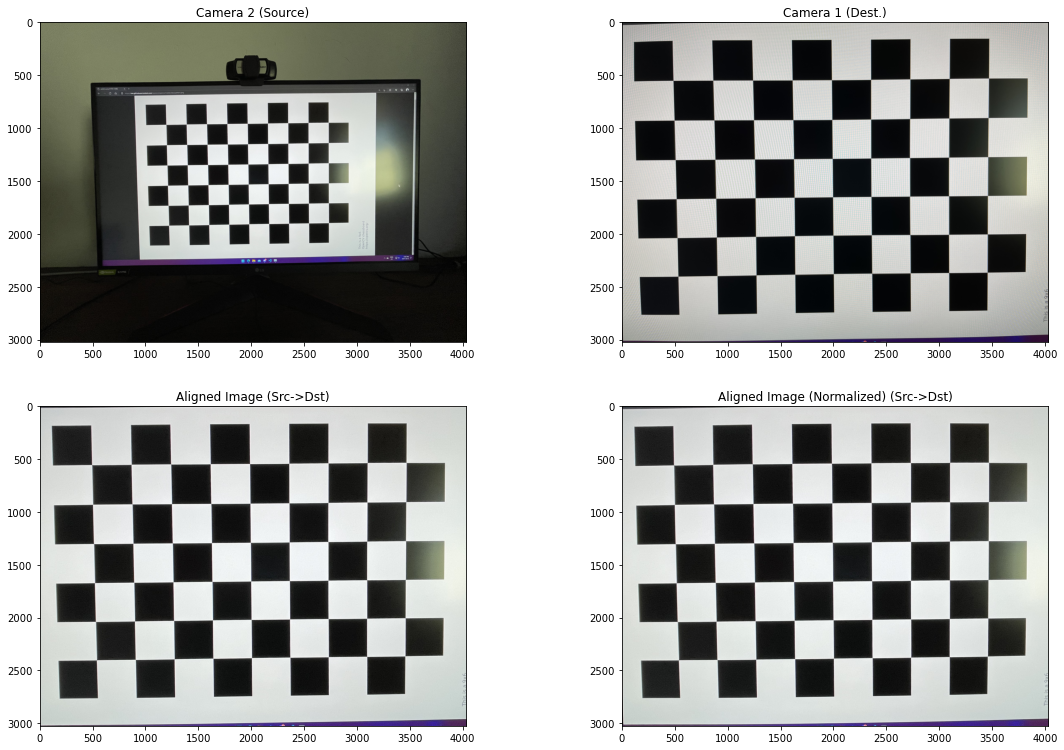

In [52]:
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.2, hspace=0.2)
plt.figure(figsize=(20,20))
ax = []
# Append plots to a list
plot = plt.subplot(gs[0, :2])
plot.set_title('Camera 2 (Source)')
plot.imshow(mpimg.imread(src_path))
ax.append(plot)
plot = plt.subplot(gs[0, 2], )
plot.set_title('Camera 1 (Dest.)')
plot.imshow(mpimg.imread(dst_path))
ax.append(plot)
plot = plt.subplot(gs[1, 0:2], )
plot.set_title('Aligned Image (Src->Dst)')
plot.imshow(aligned_img)
ax.append(plot)
plot = plt.subplot(gs[1, 2:], )
plot.set_title('Aligned Image (Normalized) (Src->Dst)')
plot.imshow(normalized_aligned_img)
ax.append(plot)

## Similarity Analysis
The similarity between the two warped images is compared to the destination image, as a quantative measure of the results

In [53]:
# import the necessary packages
from skimage.metrics import structural_similarity

In [57]:
dst_gray = cv2.cvtColor(mpimg.imread(dst_path), cv2.COLOR_RGB2GRAY)
dst_gray = cv2.undistort(dst_gray, mtx, dist, None, mtx)
aligned_gray = cv2.cvtColor(aligned_img, cv2.COLOR_RGB2GRAY)
normalized_aligned_gray = cv2.cvtColor(normalized_aligned_img, cv2.COLOR_RGB2GRAY)
aligned_score, aligned_diff = structural_similarity(dst_gray, aligned_gray, full=True)
normalized_aligned_score, normalized_aligned_diff = structural_similarity(dst_gray, normalized_aligned_gray, full=True)

In [58]:
print('Structural Similarity (Aligned vs. Normalized-Aligned): {}/{}'.format(aligned_score, normalized_aligned_score))

Structural Similarity (Aligned vs. Normalized-Aligned): 0.5380406664495423/0.5465601025399025
